# Exploratory Data Analysis on Final Dataset

## Import Needed Filepaths and Libraries

In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import re

from texas_gerrymandering_hb4.config import FINAL_CSV, CLEAN_DISTRICTS_PARQUET, RACE, FIGURES_DIR


## Load Datasets
Load final tabular dataset into a dataframe and load clean district geometry into a geodataframe.

In [26]:
df  = pd.read_csv(FINAL_CSV)
gdf = gpd.read_parquet(CLEAN_DISTRICTS_PARQUET)

## Helper Functions to Merge Datasets

### Find District ID Column

In [27]:
def candidate_cols(cols):
    pat = re.compile(r"(district(_?id)?|^cd\d*fp$|^cd$|geoid\d*$|geoid$|geocode)", re.I)
    return [c for c in cols if pat.search(c)]

### Construct District ID

In [28]:
def make_district_id_from_any(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    out = pd.Series(pd.NA, index=s.index, dtype="Int64")

    # TX GEOID like '4807' / '04807' / '4812' → take last 2
    is_tx_geoid = s.str.fullmatch(r"0?48\d{2,3}")
    out.loc[is_tx_geoid] = s[is_tx_geoid].str[-2:].astype(int)

    # 2-digit strings '01'..'38'
    mask_2dig = s.str.fullmatch(r"\d{2}")
    out.loc[mask_2dig & out.isna()] = s[mask_2dig & out.isna()].astype(int)

    # 1–2 digit integers '1'..'38'
    mask_int = s.str.fullmatch(r"\d{1,2}")
    out.loc[mask_int & out.isna()] = s[mask_int & out.isna()].astype(int)

    # Embedded trailing digits: 'CD-07', 'TX07', 'CD118FP=07'
    tail = s.str.extract(r"(\d{1,2})$")
    take = tail[0].notna() & out.isna()
    out.loc[take] = tail.loc[take, 0].astype(int)

    return out.rename("district_id")

In [29]:
def ensure_district_id(frame: pd.DataFrame) -> pd.DataFrame:
    if "district_id" in frame.columns:
        return frame
    for col in (["district_id","district","district_num","district_number",
                 "CD118FP","CD117FP","CD116FP","cd118fp","cd117fp","cd116fp",
                 "CD","cd","GEOID20","GEOID10","GEOID","geoid20","geoid10","geoid"]
                + candidate_cols(frame.columns)):
        if col in frame.columns:
            key = make_district_id_from_any(frame[col])
            if key.dropna().between(1,38).all():
                frame = frame.copy()
                frame["district_id"] = key.astype("Int64")
                return frame
    raise KeyError("Could not infer district_id. Columns seen: " + ", ".join(frame.columns))

df  = ensure_district_id(df)
gdf = ensure_district_id(gdf)

assert df["district_id"].between(1,38).all(), "Tabular district_id outside 1..38"
assert gdf["district_id"].between(1,38).all(), "Geo district_id outside 1..38"


dup_df  = df["district_id"].value_counts().loc[lambda s: s>1]
dup_gdf = gdf["district_id"].value_counts().loc[lambda s: s>1]
if not dup_df.empty:
    print("Tabular duplicates; collapsing to one per district by mean:")
    num_cols = df.select_dtypes("number").columns.tolist()
    df = df.groupby("district_id", as_index=False)[num_cols].mean()

if not dup_gdf.empty:
    raise ValueError(f"Geodata has duplicate districts: {dup_gdf.index.tolist()}")

merged = gdf.merge(df, on="district_id", how="left", validate="one_to_one")

print("Merged rows:", len(merged))
missing = set(range(1,39)) - set(merged["district_id"].unique())
print("Missing districts after merge:", sorted(missing))


Merged rows: 38
Missing districts after merge: []


In [30]:
print(df.info())
print(df.describe())

# Missing values
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   district_id        38 non-null     int64  
 1   polsby_popper      38 non-null     float64
 2   schwartzberg       38 non-null     float64
 3   convex_hull_ratio  38 non-null     float64
 4   reock              38 non-null     float64
 5   pct_white          38 non-null     float64
 6   pct_black          38 non-null     float64
 7   pct_asian          38 non-null     float64
 8   pct_hispanic       38 non-null     float64
 9   dem_share          38 non-null     float64
 10  rep_share          38 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 3.4 KB
None
       district_id  polsby_popper  schwartzberg  convex_hull_ratio      reock  \
count    38.000000      38.000000     38.000000          38.000000  38.000000   
mean     19.500000       0.221837      0.462684        

In [31]:
df.head()


,district_id,polsby_popper,schwartzberg,convex_hull_ratio,reock,pct_white,pct_black,pct_asian,pct_hispanic,dem_share,rep_share
0,1,0.193575,0.439971,0.722970,0.407570,0.632532,0.184984,0.014875,0.142830,0.252671,0.728964
1,2,0.165232,0.406487,0.625270,0.417351,0.526751,0.125050,0.072934,0.255189,0.399379,0.577517
2,3,0.216761,0.465576,0.805445,0.273916,0.577914,0.112669,0.111327,0.172895,0.403698,0.573637
3,4,0.103462,0.321654,0.574190,0.222752,0.605524,0.099241,0.157600,0.108877,0.405732,0.575123
4,5,0.184465,0.429494,0.823171,0.310183,0.522819,0.159980,0.034848,0.261670,0.481179,0.498040


In [32]:
gdf.head()

,district,area_sq_km,convex_hull_area_sq_km,convex_hull_ratio,perimeter_km,polsby_popper,reock,schwartzberg,geometry,district_id
0,1,24872.423988,34407.648538,0.722875,1270.431901,0.193653,0.410968,0.440061,"POLYGON ((-94.12963 31.09928, -94.13149 31.100...",1
1,2,1310.539397,2095.991145,0.625260,315.656491,0.165284,0.420622,0.406551,"POLYGON ((-95.53725 29.87388, -95.53732 29.877...",2
2,3,8726.001927,10833.559850,0.805460,711.485635,0.216617,0.274956,0.465422,"POLYGON ((-94.70576 32.87916, -94.70579 32.879...",3
3,4,12114.918945,21097.061568,0.574247,1213.041827,0.103462,0.223692,0.321654,"POLYGON ((-96.84412 32.98744, -96.8441 32.9889...",4
4,5,9956.758283,12095.544056,0.823176,823.654724,0.184432,0.312211,0.429456,"POLYGON ((-95.73928 31.50406, -95.7392 31.5041...",5


## Stripplot Showing Democratic Vote Share by District

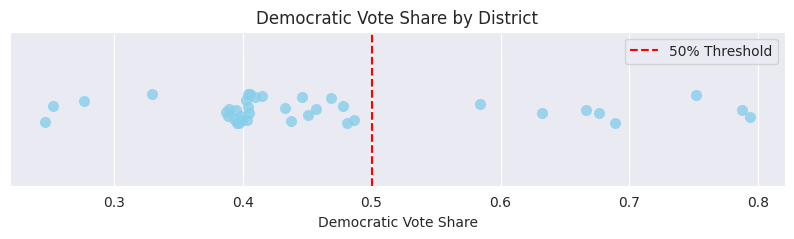

In [33]:
# --- Stripplot (better for only 38 districts) ---
plt.figure(figsize=(10, 2))

sns.stripplot(x=df["dem_share"], size=8, color="skyblue", edgecolor="black", alpha=0.8)

# Vertical 50% threshold
plt.axvline(0.5, color="red", linestyle="--", linewidth=1.5, label="50% Threshold")

plt.xlabel("Democratic Vote Share")
plt.title("Democratic Vote Share by District")
plt.legend()
plt.show()

## Stacked Bar Chart that Shows Racial Composition By District

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


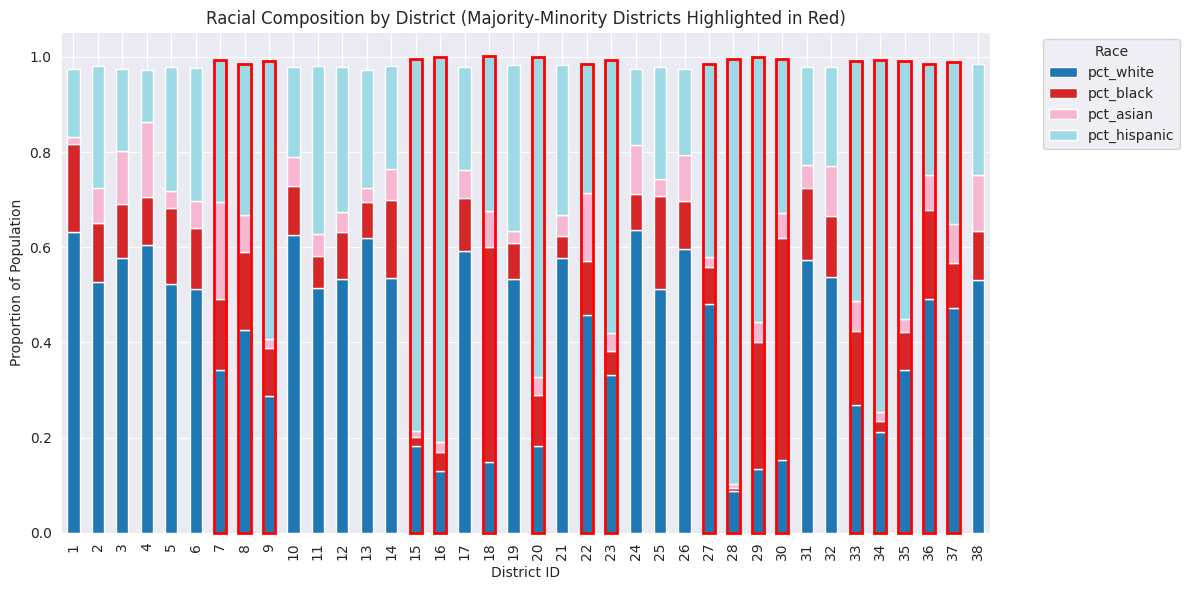

In [34]:
# Majority–minority flag (assuming pct_white in 0–1)
df["majority_minority"] = df["pct_white"] < 0.5

# Stacked bar data
df_race = df.set_index("district_id")[RACE]

# Align MM flag to the plotting index to avoid order mismatches
mm_flag = df.set_index("district_id")["majority_minority"].reindex(df_race.index)

# Plot stacked bars
ax = df_race.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")

# Rectangle size matches actual bar size
bar_width = ax.patches[0].get_width()
bar_totals = df_race.sum(axis=1).to_numpy()

for idx, (is_mm, total) in enumerate(zip(mm_flag.to_numpy(), bar_totals)):
    if bool(is_mm):  # guard against NaN
        rect = patches.Rectangle(
            (idx - bar_width / 2, 0),
            bar_width,
            total,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
            zorder=5,
            clip_on=False
        )
        ax.add_patch(rect)

plt.title("Racial Composition by District (Majority-Minority Districts Highlighted in Red)")
plt.ylabel("Proportion of Population")
plt.xlabel("District ID")
plt.legend(title="Race", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "race_stacked_bar_chart.eps", dpi=300, bbox_inches="tight")

## Stacked Bar Chart that Shows Party Shares By District

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


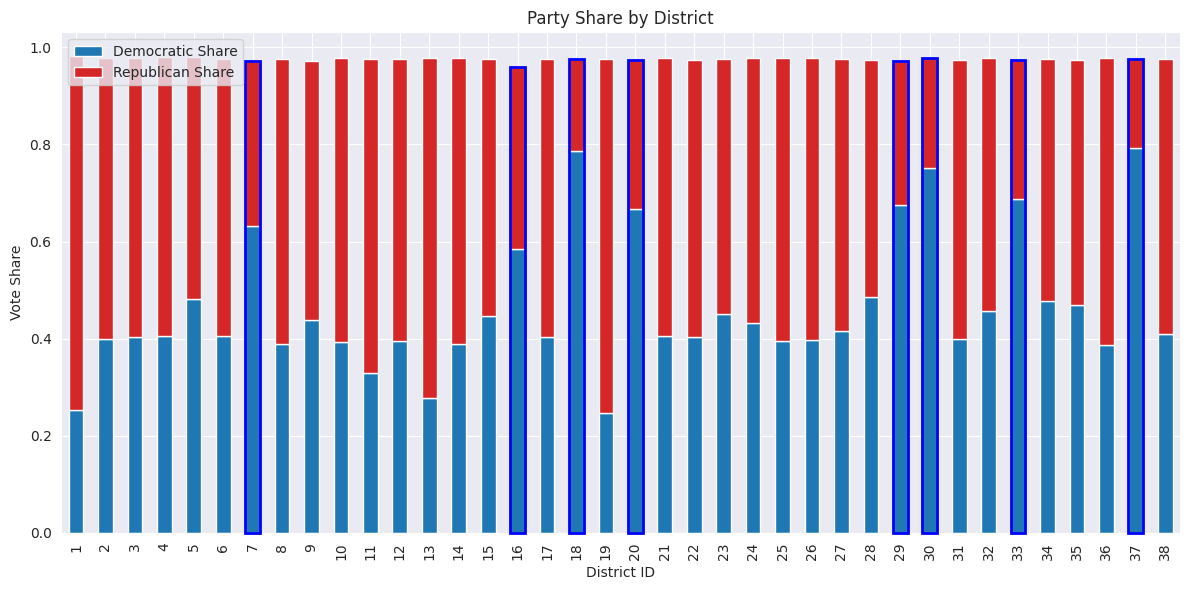

In [35]:
# Democratic district flag
df["democratic"] = df["dem_share"] > df["rep_share"]

# Select party share columns
df_party = df.set_index("district_id")[["dem_share", "rep_share"]]

democratic_flag = df.set_index("district_id")["democratic"].reindex(df_party.index)

# Plot stacked bar chart
party_colors = ["#1f77b4", "#d62728"]
ax = df_party.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    color=party_colors
)

# Rectangle size matches actual bar size
bar_width = ax.patches[0].get_width()
bar_totals = df_party.sum(axis=1).to_numpy()

for idx, (is_dem, total) in enumerate(zip(democratic_flag.to_numpy(), bar_totals)):
    if bool(is_dem):  # guard against NaN
        rect = patches.Rectangle(
            (idx - bar_width / 2, 0),
            bar_width,
            total,
            linewidth=2,
            edgecolor="blue",
            facecolor="none",
            zorder=5,
            clip_on=False
        )
        ax.add_patch(rect)

# Add labels and title
ax.set_xlabel("District ID")
ax.set_ylabel("Vote Share")
ax.set_title("Party Share by District")

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Democratic Share", "Republican Share"], loc="upper left")

fig = ax.get_figure()
fig.tight_layout()
fig.savefig(FIGURES_DIR / "party_stacked_bar_chart.eps", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)


In [36]:
df.head() #add total number and keep percentage as it is

,district_id,polsby_popper,schwartzberg,convex_hull_ratio,reock,pct_white,pct_black,pct_asian,pct_hispanic,dem_share,rep_share,majority_minority,democratic
0,1,0.193575,0.439971,0.722970,0.407570,0.632532,0.184984,0.014875,0.142830,0.252671,0.728964,False,False
1,2,0.165232,0.406487,0.625270,0.417351,0.526751,0.125050,0.072934,0.255189,0.399379,0.577517,False,False
2,3,0.216761,0.465576,0.805445,0.273916,0.577914,0.112669,0.111327,0.172895,0.403698,0.573637,False,False
3,4,0.103462,0.321654,0.574190,0.222752,0.605524,0.099241,0.157600,0.108877,0.405732,0.575123,False,False
4,5,0.184465,0.429494,0.823171,0.310183,0.522819,0.159980,0.034848,0.261670,0.481179,0.498040,False,False


## Generating Pearson and Spearman Correlation Maps

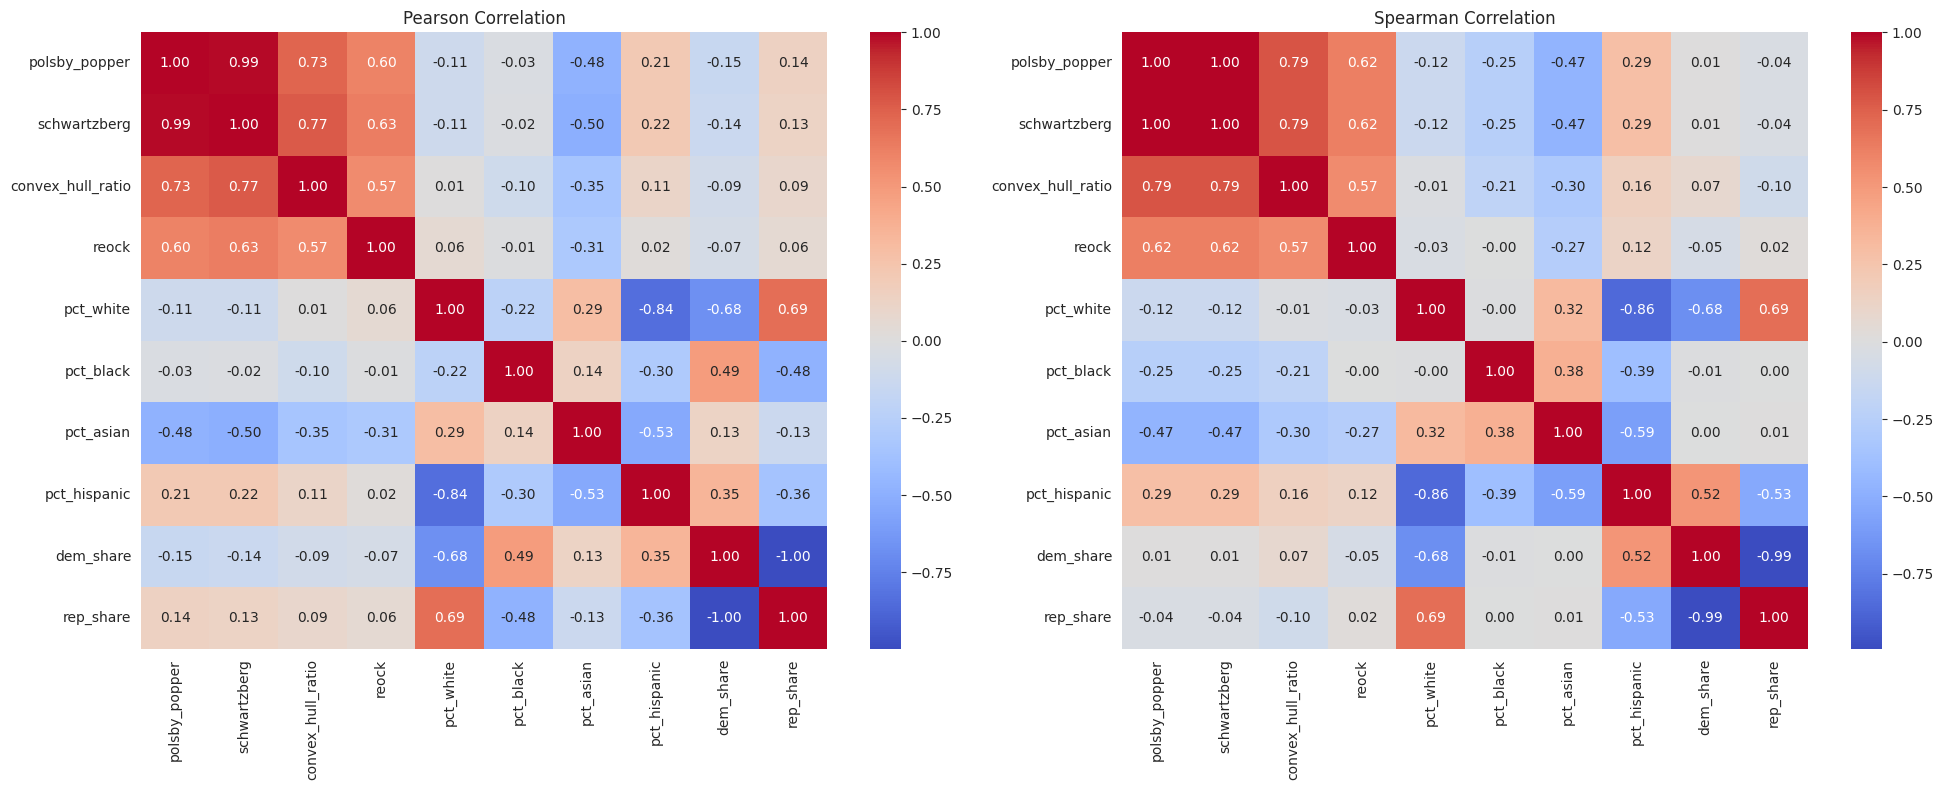

In [37]:
df_drop_districtid = df.drop(columns=["district_id", "democratic", "majority_minority"])

pearson_corr = df_drop_districtid.corr(method="pearson")
spearman_corr = df_drop_districtid.corr(method="spearman")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(
    pearson_corr,
    cmap="coolwarm", center=0, annot=True, fmt=".2f",
    ax=axes[0]
)
axes[0].set_title("Pearson Correlation")

sns.heatmap(
    spearman_corr,
    cmap="coolwarm", center=0, annot=True, fmt=".2f",
    ax=axes[1]
)
axes[1].set_title("Spearman Correlation")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "correlation_matricies.eps", dpi=300, bbox_inches="tight")
